In [78]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

Text(0.5, 1.0, 'dilated_image')

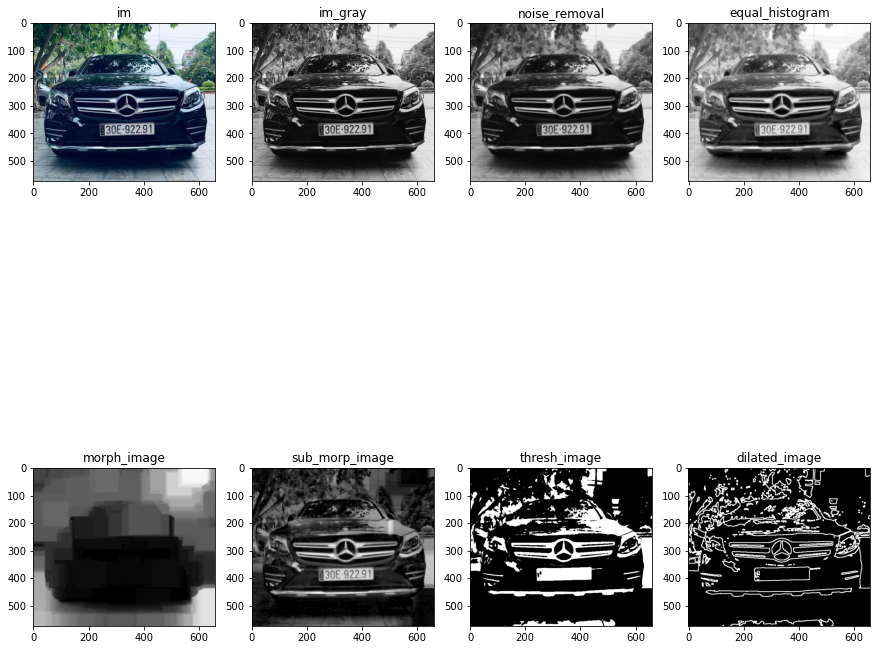

In [109]:
# Load image
im = cv2.imread("./car2.jpg")

# Chuyển ảnh về không gian màu xám
im_gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

# Giảm nhiễu làm cho các cạnh sắc nét hơn
noise_removal = cv2.bilateralFilter(im_gray,9,75,75)
# Cân bằng sáng tối hình ảnh
equal_histogram = cv2.equalizeHist(noise_removal)

# Biến đổi hình thái ảnh làm cho edge trở nên sắc nhọn
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
morph_image = cv2.morphologyEx(equal_histogram,cv2.MORPH_OPEN,kernel,iterations=20)

# Xóa background, tách biệt background và vùng sáng
sub_morp_image = cv2.subtract(equal_histogram,morph_image)
ret,thresh_image = cv2.threshold(sub_morp_image,0,255,cv2.THRESH_OTSU)

# Nhận dạng edge bằng thuật toán Canny
canny_image = cv2.Canny(thresh_image,250,255)

# Dilate các edge 
kernel = np.ones((3,3), np.uint8)
dilated_image = cv2.dilate(canny_image,kernel,iterations=1)


fig, axes = plt.subplots(2, 4, figsize=(15, 15))

axes[0][0].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
axes[0][0].set_title('im')
axes[0][1].imshow(cv2.cvtColor(im_gray, cv2.COLOR_BGR2RGB))
axes[0][1].set_title('im_gray')
axes[0][2].imshow(cv2.cvtColor(noise_removal, cv2.COLOR_BGR2RGB))
axes[0][2].set_title('noise_removal')
axes[0][3].imshow(cv2.cvtColor(equal_histogram, cv2.COLOR_BGR2RGB))
axes[0][3].set_title('equal_histogram')
axes[1][0].imshow(cv2.cvtColor(morph_image, cv2.COLOR_BGR2RGB))
axes[1][0].set_title('morph_image')
axes[1][1].imshow(cv2.cvtColor(sub_morp_image, cv2.COLOR_BGR2RGB))
axes[1][1].set_title('sub_morp_image')
axes[1][2].imshow(cv2.cvtColor(thresh_image, cv2.COLOR_BGR2RGB))
axes[1][2].set_title('thresh_image')
axes[1][3].imshow(cv2.cvtColor(dilated_image, cv2.COLOR_BGR2RGB))
axes[1][3].set_title('dilated_image')

In [110]:
# Tìm các countour từ dilated image
contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Lấy 10 contour có diện tích lớn nhất
contours= sorted(contours, key = cv2.contourArea, reverse = True)[:10]
location = None
for c in contours:
    peri = cv2.arcLength(c, True)
    # Xấp xỉ đa giác
    approx = cv2.approxPolyDP(c, 0.05 * peri, True) 
    # Nếu tìm được 4 đỉnh của hình chữ nhật -> lưu lại vị trí tọa độ 4 đỉnh
    if len(approx) == 4:
            location = approx
            break

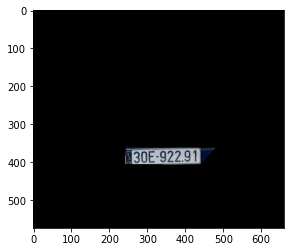

In [111]:
mask = np.zeros(im_gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(im, im, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

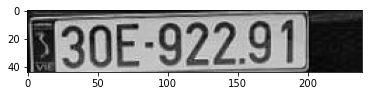

In [112]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
LpRegion = im_gray[x1:x2, y1:y2]
plt.imshow(cv2.cvtColor(LpRegion, cv2.COLOR_BGR2RGB))

In [113]:
roi = cv2.cvtColor(LpRegion, cv2.COLOR_BGR2RGB)
roi_gray = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
roi_blur = cv2.GaussianBlur(roi_gray,(3,3),1)
ret,thre = cv2.threshold(roi_blur,120,255,cv2.THRESH_BINARY_INV)
kerel3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
thre_mor = cv2.morphologyEx(thre,cv2.MORPH_DILATE,kerel3)
cont,hier = cv2.findContours(thre_mor,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

<ipython-input-114-0734df92a8b7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours = np.array(contours)


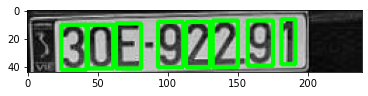

In [114]:
contour = max(contours, key=cv2.contourArea)
for contour in cont:
    (x, y, w, h) = cv2.boundingRect(contour)

    # rule to determine characters
    aspectRatio = w / float(h)
    solidity = cv2.contourArea(contour) / float(w * h)
    heightRatio = h / float(LpRegion.shape[0])

    if 0.1 < aspectRatio < 1.0 and solidity > 0.1 and 0.6 < heightRatio < 2.0:
        cv2.rectangle(roi,(x,y),(x+w,y+h),(0,255,0),2)
        contours.append(contour)
        
contours = np.array(contours)      
plt.imshow(cv2.cvtColor(roi,cv2.COLOR_BGR2RGB))

In [115]:
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

In [32]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [33]:
import keras
import numpy as np

def get_digits_data(path):
    data = np.load(path, allow_pickle=True)
    total_nb_data = len(data)
    np.random.shuffle(data)
    data_train = []

    for i in range(total_nb_data):
        data_train.append(data[i])

    print("-------------DONE------------")
    print('The number of train digits data: ', len(data_train))

    return data_train


def get_alphas_data(path):
    data = np.load(path, allow_pickle=True)
    total_nb_data = len(data)

    np.random.shuffle(data)
    data_train = []

    for i in range(total_nb_data):
        data_train.append(data[i])

    print("-------------DONE------------")
    print('The number of train alphas data: ', len(data_train))

    return data_train


class Datasets(object):
    def __init__(self):
        self.all_data = []

        # Input data
        self.digits_data = get_digits_data('./data/digits.npy')
        self.alphas_data = get_alphas_data('./data/alphas.npy')

        # Preprocess
        self.convert_data_format()

    def gen(self):
        np.random.shuffle(self.all_data)
        images = []
        labels = []

        for i in range(len(self.all_data)):
            image, label = self.all_data[i]
            images.append(image)
            labels.append(label)

        labels = keras.utils.to_categorical(labels, num_classes=32)
        return images, labels

    def convert_data_format(self):
        # Digits data
        for i in range(len(self.digits_data)):
            image = self.digits_data[i][0]
            label = self.digits_data[i][1]
            self.all_data.append((image, label))

        # Alpha data
        nb_alphas_data = len(self.alphas_data)
        for i in range(nb_alphas_data * 8):
            image = self.alphas_data[i % nb_alphas_data][0]
            label = self.alphas_data[i % nb_alphas_data][1]
            self.all_data.append((image, label))

In [34]:
dataset = Datasets()
trainX, trainY = dataset.gen()
X_train = np.array(trainX)
y_train = np.array(trainY)

-------------DONE------------
The number of train digits data:  448
-------------DONE------------
The number of train alphas data:  628


In [35]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='softmax'))

In [36]:
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(1e-3), metrics=['acc'])

In [37]:
H = model.fit(X_train, y_train, validation_split=0.15, verbose=1,
                       epochs=10, shuffle=True, batch_size=128)

Epoch 1/10
37/37 [==============================] - 7s 199ms/step - loss: 2.9737 - acc: 0.1744 - val_loss: 1.8925 - val_acc: 0.5298
Epoch 2/10
37/37 [==============================] - 7s 181ms/step - loss: 1.4247 - acc: 0.5969 - val_loss: 0.5396 - val_acc: 0.8551
Epoch 3/10
37/37 [==============================] - 7s 189ms/step - loss: 0.6620 - acc: 0.7929 - val_loss: 0.2884 - val_acc: 0.9062
Epoch 4/10
37/37 [==============================] - 7s 187ms/step - loss: 0.4342 - acc: 0.8615 - val_loss: 0.1479 - val_acc: 0.9586
Epoch 5/10
37/37 [==============================] - 7s 184ms/step - loss: 0.3313 - acc: 0.8895 - val_loss: 0.1309 - val_acc: 0.9610
Epoch 6/10
37/37 [==============================] - 7s 193ms/step - loss: 0.2705 - acc: 0.9099 - val_loss: 0.1089 - val_acc: 0.9708
Epoch 7/10
37/37 [==============================] - 7s 187ms/step - loss: 0.2022 - acc: 0.9333 - val_loss: 0.0845 - val_acc: 0.9695
Epoch 8/10
37/37 [==============================] - 7s 196ms/step - loss: 0.

In [52]:
ALPHA_DICT = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P',
              13: 'R', 14: 'S', 15: 'T', 16: 'U', 17: 'V', 18: 'X', 19: 'Y', 20: 'Z', 21: '0', 22: '1', 23: '2', 24: '3',
              25: '4', 26: '5', 27: '6', 28: '7', 29: '8', 30: '9', 31: "Background"}
res = ""
for contour in contours: 
    (x,y,w,h) = cv2.boundingRect(contour)
    roi = thre[y:y+h,x:x+w]
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    num_pred = model.predict_on_batch(roi.reshape(1,28,28,1))
    num = ALPHA_DICT[np.argmax(num_pred)]
    res += num

In [53]:
res

'3DE92291'

In [54]:
approx

array([[[479, 362]],

       [[245, 361]],

       [[240, 404]],

       [[440, 405]]], dtype=int32)

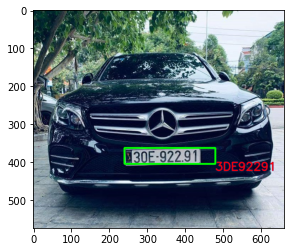

In [57]:
font = cv2.FONT_HERSHEY_SIMPLEX
out = cv2.putText(im, text=res, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,0,255), thickness=2, lineType=cv2.LINE_AA)
out = cv2.rectangle(im, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

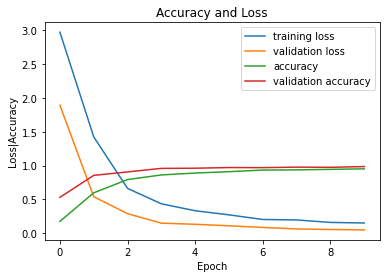

In [61]:
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['acc'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_acc'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [69]:
# SVM
from sklearn.model_selection import train_test_split
train_images = X_train.reshape(-1,784)
train_labels = np.argmax(y_train, axis = 1)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size = 0.2)
from sklearn import svm, metrics
clf = svm.SVC()
clf.fit(train_images, train_labels)

SVC()

In [71]:
predict = clf.predict(val_images)
ac_score = metrics.accuracy_score(val_labels, predict)
cl_report = metrics.classification_report(val_labels, predict)
print("Score = ", ac_score)
print(cl_report)

Score =  0.993607305936073
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.97      1.00      0.98        97
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        82
           4       1.00      1.00      1.00       124
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        30
           7       1.00      1.00      1.00        89
           8       0.95      1.00      0.97        19
           9       1.00      1.00      1.00        28
          10       1.00      1.00      1.00        26
          11       1.00      1.00      1.00        38
          12       1.00      1.00      1.00        98
          13       1.00      1.00      1.00        39
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        11
          16       1.00      1.00      1.00        65


In [72]:
from sklearn.model_selection import GridSearchCV

parameter_candidates = [
  {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000]},
]

clf = GridSearchCV(estimator=svm.SVC(), param_grid=parameter_candidates, n_jobs=-1)
clf.fit(train_images, train_labels)
print('Best score:', clf.best_score_)
print('Best C:',clf.best_estimator_.C)

Best score: 0.9972581865622961
Best C: 5


In [73]:
clf = svm.SVC(C=5)
clf.fit(train_images, train_labels)

SVC(C=5)

In [74]:
predict = clf.predict(val_images)
ac_score = metrics.accuracy_score(val_labels, predict)
cl_report = metrics.classification_report(val_labels, predict)
print("Score = ", ac_score)
print(cl_report)

Score =  0.9981735159817352
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.99      1.00      0.99        97
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        82
           4       1.00      1.00      1.00       124
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        30
           7       1.00      1.00      1.00        89
           8       0.95      1.00      0.97        19
           9       1.00      1.00      1.00        28
          10       1.00      1.00      1.00        26
          11       1.00      1.00      1.00        38
          12       1.00      1.00      1.00        98
          13       1.00      1.00      1.00        39
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        11
          16       1.00      1.00      1.00        65

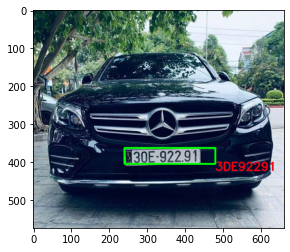

In [75]:
resSVM = ""
for contour in contours: 
    (x,y,w,h) = cv2.boundingRect(contour)
    roi = thre[y:y+h,x:x+w]
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    num_pred = model.predict_on_batch(roi.reshape(1,28,28,1))
    num = ALPHA_DICT[np.argmax(num_pred)]
    resSVM += num

out2 = cv2.putText(im, text=resSVM, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,0,255), thickness=2, lineType=cv2.LINE_AA)
out2 = cv2.rectangle(im, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(out2, cv2.COLOR_BGR2RGB))